# ISSS610-Applied Machine Learning
## Business Problem
The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Data Set
This dataset contains 119390 observations for a City Hotel and a Resort Hotel. Each observation represents a hotel booking between the 1st of July 2015 and 31st of August 2017, including booking that effectively arrived and booking that were canceled.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

Done By 
- Anna Choo Xin Yi
- Filbert
- Wesley Djingga
- Xie Jianlong
- Zhang Jieyuan


# Import Libraries

In [1]:
#Import all here
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import dill as pickle
import seaborn as sns
from os.path import exists
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## Data Retrival

In [2]:
x_under_train,x_under_test,y_under_train,y_under_test,x_train,x_test,y_train,y_test = pickle.load(open("2.out.x_y_train_test", 'rb'))

## Random Forest

### Feature Engineering

### Train my hot encoder

In [3]:
categorical = ['ArrivalDateWeekNumber', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'Hotel']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(x_train[categorical])
pickle.dump(enc,open("3a.out.enc",'wb'))

### Create my forest Transform function

In [4]:
def forest_transform(input_x):
    enc = pickle.load(open("3a.out.enc", 'rb'))
    categorical = ['ArrivalDateWeekNumber', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'Hotel']
    numerical = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'TotalOfSpecialRequests']
    input_x_one_hot_data = enc.transform(input_x[categorical]).toarray()
    input_x_one_hot_data_df= pd.DataFrame(input_x_one_hot_data)
    input_x_one_hot_data = pd.concat([input_x_one_hot_data_df, input_x[numerical].reset_index(drop=True),], axis=1)
    return input_x_one_hot_data

pickle.dump(forest_transform,open("3a.out.forest_transform",'wb'))


## Test Default Result

### Without Down Sampling

In [5]:
#1m 4.6s
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(random_state= 2021)
forest.fit(forest_transform(x_train), y_train)

# Make predictions for the test set
y_pred_test_forest = forest.predict(forest_transform(x_test))

# # View accuracy score
print(accuracy_score(y_test, y_pred_test_forest))

# # View confusion matrix for test_forest data and predictions
print(confusion_matrix(y_test, y_pred_test_forest))

# View the classification report for test_forest data and predictions
print(classification_report(y_test, y_pred_test_forest))

0.883037646040675
[[13499   912]
 [ 1791  6908]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     14411
           1       0.88      0.79      0.84      8699

    accuracy                           0.88     23110
   macro avg       0.88      0.87      0.87     23110
weighted avg       0.88      0.88      0.88     23110



### With Down Sampling

In [6]:
#45s
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(random_state= 2021)
forest.fit(forest_transform(x_under_train), y_under_train)

# Make predictions for the test set
y_under_pred_test_forest = forest.predict(forest_transform(x_under_test))

# # View accuracy score
print(accuracy_score(y_under_test, y_under_pred_test_forest))

# # View confusion matrix for test_forest data and predictions
print(confusion_matrix(y_under_test, y_under_pred_test_forest))

# View the classification report for test_forest data and predictions
print(classification_report(y_under_test, y_under_pred_test_forest))

0.8743235463442718
[[7667 1003]
 [1180 7520]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      8670
           1       0.88      0.86      0.87      8700

    accuracy                           0.87     17370
   macro avg       0.87      0.87      0.87     17370
weighted avg       0.87      0.87      0.87     17370



## Hyper Parameter Tuning - Using no downsampling

### Grid Search CV

In [7]:
#51m 46.1s
forest=RandomForestClassifier(random_state=2021)
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'oob_score': [True,False],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)
CV_rfc.fit(forest_transform(x_train), y_train)
CV_rfc.best_params_
#{'criterion': 'gini', 'max_features': 'auto', 'oob_score': True}

{'criterion': 'gini', 'max_features': 'auto', 'oob_score': True}

### Visualize Each Parameter

[Text(0.5, 0, 'Max Depth'), Text(0, 0.5, 'F1 Score')]

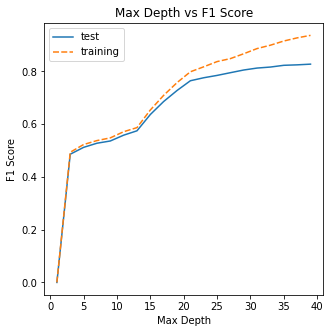

In [8]:
#15m 16.9s
f1sTrain = []
f1sTest = []
maxdepthRange = [x for x in range(1,40,2)]
for maxdepth in maxdepthRange:
    forest = RandomForestClassifier(random_state= 2021, max_features='auto', oob_score=True, max_depth=maxdepth)
    forest.fit(forest_transform(x_train), y_train)
    y_pred = forest.predict(forest_transform(x_train))
    f1sTrain.append(round(f1_score(y_train, y_pred),6))
    y_pred = forest.predict(forest_transform(x_test))
    f1sTest.append(round(f1_score(y_test, y_pred),6))
plt.figure(figsize=(5,5))
p = sns.lineplot(data=pd.DataFrame(data={'test': pd.Series(f1sTest, index=maxdepthRange),'training': pd.Series(f1sTrain, index=maxdepthRange)}))   
p.set_title("Max Depth vs F1 Score")
p.set( xlabel = "Max Depth", ylabel = "F1 Score")

#Best Max Depth is 20 

[Text(0.5, 0, 'Min Sample Split'), Text(0, 0.5, 'F1 Score')]

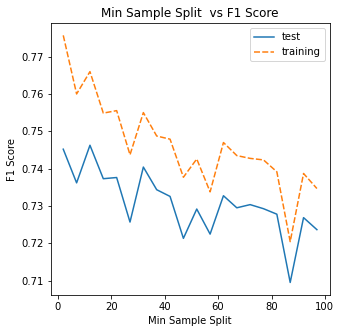

In [9]:
#14m 54.8s
f1sTrain2 = []
f1sTest2 = []
minSplitRange = [x for x in range(2,100,5)]
for minSplit in minSplitRange:
    forest = RandomForestClassifier( random_state= 2021, max_features='auto', oob_score=True, max_depth=20, min_samples_split=minSplit)
    forest.fit(forest_transform(x_train), y_train)
    y_pred = forest.predict(forest_transform(x_train))
    f1sTrain2.append(round(f1_score(y_train, y_pred),6))
    y_pred = forest.predict(forest_transform(x_test))
    f1sTest2.append(round(f1_score(y_test, y_pred),6))
plt.figure(figsize=(5,5))
p = sns.lineplot(data=pd.DataFrame(data={'test': pd.Series(f1sTest2, index=minSplitRange),'training': pd.Series(f1sTrain2, index=minSplitRange)}))    
p.set_title("Min Sample Split  vs F1 Score")
p.set( xlabel = "Min Sample Split", ylabel = "F1 Score")

#Best Min Samples Split is 2

[Text(0.5, 0, 'Max Terminal Nodes'), Text(0, 0.5, 'F1 Score')]

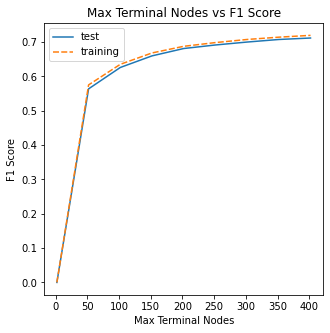

In [10]:
#5m 18.8s
f1sTrain3 = []
f1sTest3 = []
maxNodeRange = [x for x in range(2,403,50)]
for maxNode in maxNodeRange:
    forest = RandomForestClassifier( random_state= 2021, max_features='auto', oob_score=True, max_depth=20, min_samples_split=2,max_leaf_nodes=maxNode)
    forest.fit(forest_transform(x_train), y_train)
    y_pred = forest.predict(forest_transform(x_train))
    f1sTrain3.append(round(f1_score(y_train, y_pred),6))
    y_pred = forest.predict(forest_transform(x_test))
    f1sTest3.append(round(f1_score(y_test, y_pred),6))
d = { 'test': pd.Series(f1sTest3, index=maxNodeRange),'training': pd.Series(f1sTrain3, index=maxNodeRange)}
plt.figure(figsize=(5,5))
p = sns.lineplot(data=pd.DataFrame(data=d))   
p.set_title("Max Terminal Nodes vs F1 Score")
p.set(xlabel = "Max Terminal Nodes", ylabel = "F1 Score") 

#Best Max Leaf Node is 40

[Text(0.5, 0, 'nEstimator'), Text(0, 0.5, 'F1 Score')]

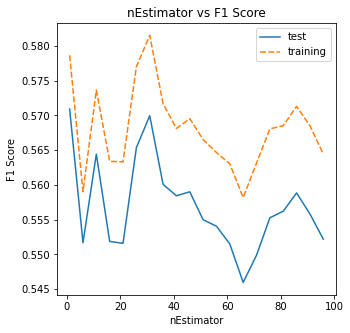

In [11]:
#5m 20.2s
f1sTrain4 = []
f1sTest4 = []
nEstimatorRange = [x for x in range(1,100,5)]
for nEstimator in nEstimatorRange:
    forest = RandomForestClassifier(random_state= 2021, max_features='auto', oob_score=True, max_depth=20, min_samples_split=2,max_leaf_nodes=40,n_estimators= nEstimator)
    forest.fit(forest_transform(x_train), y_train)
    y_pred = forest.predict(forest_transform(x_train))
    f1sTrain4.append(round(f1_score(y_train, y_pred),6))
    y_pred = forest.predict(forest_transform(x_test))
    f1sTest4.append(round(f1_score(y_test, y_pred),6))
plt.figure(figsize=(5,5))
p = sns.lineplot(data=pd.DataFrame(data={'test': pd.Series(f1sTest4, index=nEstimatorRange),'training': pd.Series(f1sTrain4, index=nEstimatorRange)}))   
p.set_title("nEstimator vs F1 Score")
p.set( xlabel = "nEstimator", ylabel = "F1 Score")  

#Best N_Estimator = 30

[Text(0.5, 0, 'Min Sample Leaf'), Text(0, 0.5, 'F1 Score')]

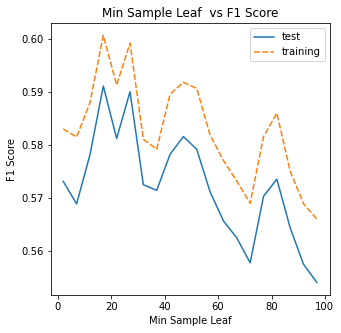

In [12]:
#3min 52.7s
f1sTrain5 = []
f1sTest5 = []
minSampleLeafRange = [x for x in range(2,102,5)]
for minSampleLeaf in minSampleLeafRange:
    forest = RandomForestClassifier(random_state= 2021, max_features='auto', oob_score=True,  max_depth=20, min_samples_split=2,max_leaf_nodes=40,n_estimators= 30, min_samples_leaf=minSampleLeaf)
    forest.fit(forest_transform(x_train), y_train)
    y_pred = forest.predict(forest_transform(x_train))
    f1sTrain5.append(round(f1_score(y_train, y_pred),6))
    y_pred = forest.predict(forest_transform(x_test))
    f1sTest5.append(round(f1_score(y_test, y_pred),6))
plt.figure(figsize=(5,5))
p = sns.lineplot(data=pd.DataFrame(data={'test': pd.Series(f1sTest5, index=minSampleLeafRange),'training': pd.Series(f1sTrain5, index=minSampleLeafRange)}))    
p.set_title("Min Sample Leaf  vs F1 Score")
p.set( xlabel = "Min Sample Leaf", ylabel = "F1 Score")

#Min Sample Leaf 20

## Final Result -With Downsampling with Hyperparameter Tuned

In [6]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(random_state= 2021, max_features='auto', oob_score=True, max_depth=20, min_samples_split=2,max_leaf_nodes=40,n_estimators= 30, min_samples_leaf=20,)
forest.fit(forest_transform(x_under_train), y_under_train)

# Make predictions for the test set
y_under_pred_test_forest = forest.predict(forest_transform(x_under_test))

# # View accuracy score
print(accuracy_score(y_under_test, y_under_pred_test_forest))

# # View confusion matrix for test_forest data and predictions
print(confusion_matrix(y_under_test, y_under_pred_test_forest))

# View the classification report for test_forest data and predictions
print(classification_report(y_under_test, y_under_pred_test_forest))

#Accuracy Lower but should not be overfitted.

0.8099597006332757
[[7860  810]
 [2491 6209]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      8670
           1       0.88      0.71      0.79      8700

    accuracy                           0.81     17370
   macro avg       0.82      0.81      0.81     17370
weighted avg       0.82      0.81      0.81     17370



## Performance Measure

In [14]:
# prepare the cross-validation procedure
cv = KFold(n_splits=3, random_state=2021, shuffle=True)
# create model
model = RandomForestClassifier(random_state= 2021, max_features='auto', oob_score=True, max_depth=20, min_samples_split=2,max_leaf_nodes=40,n_estimators= 30, min_samples_leaf=20)
# evaluate model
scores = cross_val_score(model, forest_transform(x_train), y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.770 (0.004)


### ROC

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.901


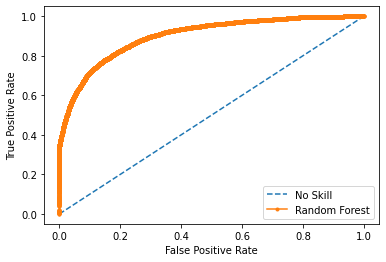

In [9]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
# predict probabilities
lr_probs = forest.predict_proba(forest_transform(x_test))
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Export

In [10]:
pickle.dump(forest, open('3a.out.forest', 'wb'))


In [19]:
categorical = ['ArrivalDateWeekNumber', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType', 'Hotel']
numerical = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'TotalOfSpecialRequests']
colnames = enc.get_feature_names(categorical)


In [70]:
columnfeature = colnames.tolist() + numerical
forest_feature = pd.DataFrame(forest.feature_importances_,index=columnfeature).sort_values(by=0,ascending=False).head(40)
forest_feature = forest_feature.head(40)

<AxesSubplot:xlabel='0'>

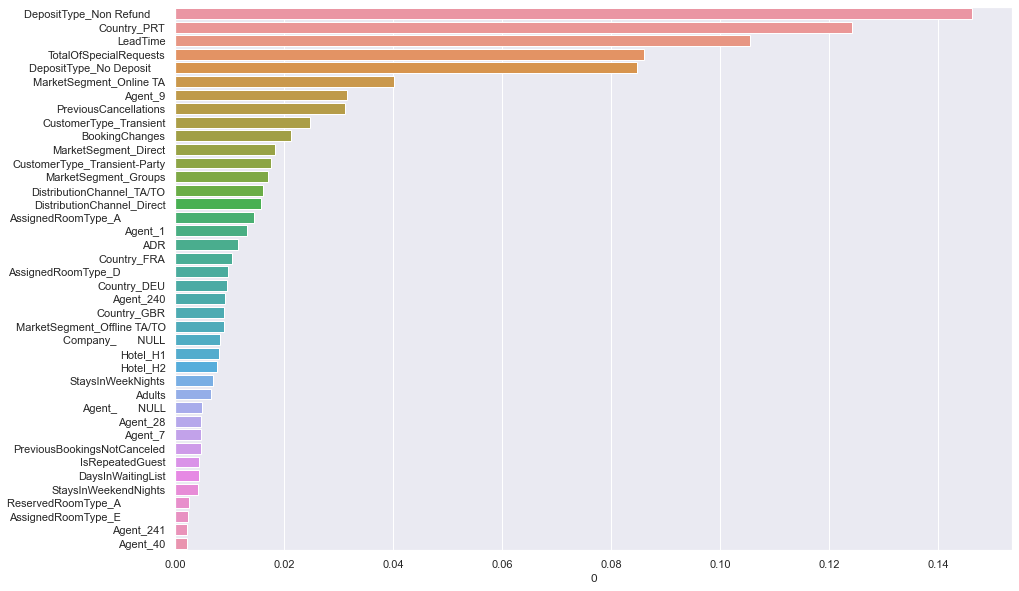

In [74]:
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(data=forest_feature, y=forest_feature.index, x=0,)